# Courseroad Optimization

## Installing Packages

In [1]:
# Install packages
import gurobipy as gp
from gurobipy import Model, GRB
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

## Importing and Setting up Data

In [2]:
# Read CSV files
data_6_4 = pd.read_csv("6-4_requirements.csv")
course_data = pd.read_csv("course_data_predicted.csv")

# Inner join on the 'no' column
data = pd.merge(course_data, data_6_4, on="no")

# Sort the resulting DataFrame by the 'no' column
data.sort_values(by="no", inplace=True)

### (NEW) Remove Certain Classes that are unrealistic

#### Classes in non-numerical course department other than CMS, STS, or WGS

In [3]:
data = data[data['no'].apply(lambda x: x[0].isdigit() or x.split('.')[0] in ['STS', 'CMS', 'WGS'])].reset_index(drop=True)

#### Non-course 6 graduate classes

In [4]:
cond1 = data['le'] == 'G'
cond2 = ~data['no'].str.startswith('6')

In [5]:
data = data[~(cond1 & cond2)].reset_index(drop=True)

#### Classes with <= than 6 units (other than 6.100A)

In [6]:
cond1 = data['vu'] <= 6.0
cond2 = data['no'] != '6.100A'

In [7]:
data = data[~(cond1 & cond2)].reset_index(drop=True)

#### Classes that are no longer offered

In [33]:
cond = data['no'] != '24.221'
data = data[cond].reset_index(drop=True)

In [34]:
# Set Variables
classes = len(data)
semesters = 8

In [35]:
classes

1206

### Data Directly from CSV

In [36]:
# Get basic class information
names = data["no"]
fall = data["fa"]
spring = data["sp"]
U = data["vu"]  # units
R = data["ra"]  # ratings
H = data["h"]   # hours
same_as = data["sa"]
pre_reqs = data["pr"]

# Get GIR-related information
hh = data["hh"]
ha = data["ha"]
hs = data["hs"]
he = data["he"]
cih = data["ci"]
ci_hw = data["cw"]
rest = data["re"]
lab = data["la"]
bio = data["bio"]
chem = data["ch"]
phys1 = data["p1"]
phys2 = data["p2"]
calc1 = data["c1"]
calc2 = data["c2"]

# Get 6-4-related information
programming = data["p-64"]
foundation = data["f-64"]
math2 = data["m2-64"]
math3 = data["m3-64"]
datac = data["dac-64"]
mod = data["moc-64"]
decision = data["dec-64"]
compute = data["coc-64"]
human = data["huc-64"]
cim_6_4 = data["cim-64"]
cim2 = data["cim2-64"]
serc = data["serc"]
aus = data["aus"]
eecs = data["eecs"]

### Data Processing

In [37]:
# Convert pre_reqs to a nested list
pre_reqs = [ast.literal_eval(pre_reqs[i]) for i in range(len(pre_reqs))]

In [38]:
classes_w_pr = set()
classes_are_pr = set()


# Build lists classes_w_pr and classes_are_pr
for i in range(classes):
    p = pre_reqs[i]
    
    # class has pre reqs
    if len(p) > 0:
        classes_w_pr.add(i)
    
    for j in range(len(p)):
        constraint = p[j]
        
        # add 1 to list for each constraint
        for p_class in constraint:
            try: # can't find some of the classes
                ind = names.tolist().index(p_class)
                classes_are_pr.add(ind)
            except:
                continue

classes_w_pr = list(classes_w_pr)
classes_w_pr.sort()

classes_are_pr = list(classes_are_pr)
classes_are_pr.sort()


# Making matrix for pre-reqs
PR = []


for i in classes_w_pr:
    
    # now p should be non-empty
    p = pre_reqs[i]
                        
    # initialize class_PR. Will be of size len(classes_are_pr) x len(p)
    class_PR = []
    
    # initially class_PR will have one row for each pre-req
    for j in range(len(p)):
        constraint = p[j]
        one_hot = np.zeros(len(classes_are_pr))
        
        # add 1 to list for each constraint
        for p_class in constraint:
            try: # can't find some of the classes
                ind_by_name = names.tolist().index(p_class)
                ind_classes_are_pr = classes_are_pr.index(ind_by_name)
                one_hot[ind_classes_are_pr] = 1
            except:
                continue
        class_PR.append(one_hot)
                                    
    PR.append(np.transpose(np.array(class_PR)))
    
# sanity check
print(sum(PR[0])) # should be 2 for 1801 and 1801A

[2.]


In [39]:
# Determining which classes are hasses
hass = [1 if (hh[i] == 1 or ha[i] == 1 or hs[i] == 1 or he[i] == 1) else 0 for i in range(classes)]

# Making matrix of GIR requirements 
G = np.column_stack((ha, hs, hh, cih, hass, bio, phys1, phys2, calc1, calc2, chem, rest, lab))
G_sat = [1, 1, 1, 2, 8, 1, 1, 1, 1, 1, 1, 12, 12]

# Making matrix for fall/spring classes
A = np.column_stack((fall, spring))

# Make vector indicating whether a semester is a fall (1) or spring (2) semester
S = [0 if j % 2 == 0 else 1 for j in range(semesters)]

# Get 1801A and 1802A indices
calc1A = names.tolist().index("18.01A")
calc2A = names.tolist().index("18.02A")

# Making matrices for 6-4 requirements
# center = [1 if (datac[i] == 1 or mod[i] == 1 or decision[i] == 1 or compute[i] == 1 or human[i] == 1) else 0 for i in range(classes)]
aus_cim6_4 = [1 if (aus[i] == 1 or cim_6_4[i] == 1) else 0 for i in range(classes)]
aus_cim2 = [1 if (aus[i] == 1 or cim2[i] == 1) else 0 for i in range(classes)]

M = np.column_stack((programming, foundation, math2, math3, datac, mod, decision, compute, human, serc, cim_6_4, cim2, aus_cim6_4, aus_cim2))
M_sat = [1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3]

EM = eecs #[1 if (eecs[i] == 1 or names[i][:2] == "18") else 0 for i in range(classes)]
EM = EM-calc1-calc2

In [112]:
# Normalize each array separately
min_val_H, max_val_H = np.min(H), np.max(H)
min_val_R, max_val_R = np.min(R), np.max(R)

normalized_H = (H - min_val_H) / (max_val_H - min_val_H)
normalized_R = (R - min_val_R) / (max_val_R - min_val_R)

# Adjust scaling factors to make the sum of weights equal
H_scaled = normalized_H * (1.0 / (1.0 + (max_val_R - min_val_R) / (max_val_H - min_val_H)))
R_scaled = normalized_R * (1.0 / (1.0 + (max_val_H - min_val_H) / (max_val_R - min_val_R)))

## Tweakable variables

In [168]:
a = 0.0

## Building the Model

### Index references
i: class

j: semester

k: index of GIR requirement

l: index of 6-4 requirement

### Model Definition

In [169]:
# Create a Gurobi model
model = Model()

# Decision variables

# Which classes to take
X = {}
for i in range(classes):
    for j in range(semesters):
        X[i, j] = model.addVar(vtype=GRB.BINARY, name=f"X_{i}_{j}")
        
# Whether class i counts towards 6-4 constraint l (listed in M)
C = {}
for i in range(classes):
    for l in range(M.shape[1]):
        C[i, l] = model.addVar(vtype=GRB.BINARY, name=f"C_{i}_{l}")
                
# Whether class i is an extra EECS math class
E = {}
for i in range(classes):
    E[i] = model.addVar(vtype=GRB.BINARY, name=f"E_{i}")
                
        
# Objective
model.setObjective(
    a * sum(H_scaled[i] * sum(X[i, j] for j in range(semesters)) for i in range(classes))
    - (1 - a) * sum(R_scaled[i] * sum(X[i, j] for j in range(semesters)) for i in range(classes)),
    GRB.MINIMIZE,
)

# ---- Variable Constraints ------

# Class i must be eecs or math class to count as the extra eecs/math class
for i in range(classes):
    model.addConstr(E[i] <= EM[i])
  
# Class i cannot count towards ANY 6-4 constraint (cannot both be 1)
for i in range(classes):
    for l in range(M.shape[1]):
        model.addConstr(E[i] + C[i,l] <= 1)
                            
# Cannot have C[i,l] = 1 if X[i,j] != 1 for any semester
for i in range(classes):
    for l in range(M.shape[1]):
        model.addConstr(
          C[i,l] <= sum(X[i,j] for j in range(semesters))            
        )
        
#Cannot have E[i] = 1 if X[i,j] != 1 for any semester * added
for i in range(classes):
    model.addConstr(
          E[i] <= sum(X[i,j] for j in range(semesters))            
        )

# Cannot have C[i,l] = 1 if M[i,l] != 1
for i in range(classes):
    for l in range(M.shape[1]):
        model.addConstr(
          C[i,l] <= M[i,l]           
        )
                                    
# ---- General Constraints ------
                                    
# Cannot take a class more than once
for i in range(classes):
    model.addConstr(sum(X[i, j] for j in range(semesters)) <= 1, name=f"num_times_{i}")

# Maximum and minimum number of units per semester
for j in range(semesters):
    model.addConstr(
        sum(U[i] * X[i, j] for i in range(classes)) <= 60, name=f"max_units_{j}"
    )
    model.addConstr(
        sum(U[i] * X[i, j] for i in range(classes)) >= 36, name=f"min_units_{j}"
    )

# Fall classes taken in fall, spring classes taken in spring
for i in range(classes):
    for j in range(semesters):
        model.addConstr(X[i, j] - A[i, S[j]] <= 0, name=f"fall_spring_{i}_{j}")

# Pre-reqs
for i in range(len(classes_w_pr)):
    for j in range(semesters):
        for k in range(PR[i].shape[1]):
            model.addConstr(
                X[classes_w_pr[i], j] * sum(sum(X[classes_are_pr[z], w] for w in range(0,j)) * PR[i][z][k] for z in range(len(classes_are_pr)))
                >= X[classes_w_pr[i], j] * 1,
                name=f"pre_req_constraint_{i}_{j}_{k}",
            )


# ---- GIR Constraints ------

# GIR requirements by classes
for k in range(11):
    model.addConstr(
        sum(G[i, k] * X[i, j] for j in range(semesters) for i in range(classes)) >= G_sat[k],
        name=f"gir_classes_{k}",
    )

# GIR requirements by units
for k in range(11, 13):
    model.addConstr(
        sum(G[i, k] * X[i, j] * U[i] for j in range(semesters) for i in range(classes)) >= G_sat[k],
        name=f"gir_units_{k}",
    )


# at least 180 units beyond GIR
model.addConstr(
    sum(
        sum(U[i] * X[i, j] for j in range(semesters))
        - sum(U[i] * X[i, j] for j in range(semesters))
        * (sum(G[i, k] for k in range(G.shape[1])) >= 1)
        for i in range(classes)
    )
    >= 180,
    name="units_beyond_GIR",
)

# Takes 1801A and 1802A in the same semester
for j in range(semesters):
    model.addConstr(X[calc1A, j] == X[calc2A, j], name=f"calcA_sameas_{j}")

# ---- 6-4 Constraints ------

# General requirements satisfied
for l in range(M.shape[1]):
    model.addConstr(
        sum(M[i, l]* C[i,l] * sum(X[i, j] for j in range(semesters)) for i in range(classes)) == M_sat[l],
        name=f"general_64_{l}",
    )
    
#Different class for each center
for i in range(classes):
    model.addConstr(
        gp.quicksum([C[i,l] for l in range(4,9)]+[C[i,11]]) <= 1, name=f"one_center_{i}",
    )

# One additional math/eecs course
model.addConstr(
    sum(E[i] for i in range(classes))== 1,
    name=f"math_eecs_{l}",
)


# ------ Hard Coded Constraints ------

# Can't take 18.06 and 18.C06
model.addConstr(
    sum(X[names.to_list().index('18.06'), j] + X[names.to_list().index('18.C06'), j] for j in range(semesters)) <= 1
)


# One hass class per semester
for j in range(semesters):
    model.addConstr(
    sum(hass[i]*X[i,j] for i in range(classes)) == 1
    )


#normalize ratings and hours


In [163]:
model.write("model.lp")

In [170]:
model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 66301 rows, 27738 columns and 282023 nonzeros
Model fingerprint: 0xafa80512
Model has 7917 quadratic constraints
Variable types: 0 continuous, 27738 integer (27738 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [4e-02, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
  QRHS range       [1e+00, 3e+00]
Presolve removed 62567 rows and 23233 columns
Presolve time: 0.27s
Presolved: 4479 rows, 4749 columns, 34218 nonzeros
Variable types: 0 continuous, 4749 integer (4749 binary)

Root relaxation: objective -5.700032e+00, 5471 iterations, 0.18 seconds (0.23 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It

In [171]:
model.objVal

-5.577178260192022

In [172]:
for j in range(semesters):
    classes_taken = []
    for i in range(classes):
        val = X[i, j].X
        if np.isclose(val, 1.0, rtol=1e-05):
            classes_taken.append(names[i])
    print("semester", j+1, ": ", classes_taken)

for j in range(semesters):
    units = 0
    for i in range(classes):
        val = X[i, j].X
        units += U[i]*val
    print("semester", j+1, " units: ", units)

# index_of_hass = names.tolist().index('21.THT')
# print(U[index_of_hass])

semester 1 :  ['1.057', '15.0111', '15.305', '20.005', '3.983', '6.100A', '6.UAT']
semester 2 :  ['11.139', '15.0251', '15.9001', '18.01', '6.1010', '9.55']
semester 3 :  ['15.874', '18.022', '21M.605', '21M.809', '6.9280', '8.01L']
semester 4 :  ['1.016', '18.03', '2.00B', '21M.490', '6.4200', '8.282']
semester 5 :  ['18.C06', '6.1200', '6.4590', '6.8371', '7.015']
semester 6 :  ['12.402', '2.00A', '20.260', '21M.480', '6.3700', '8.022']
semester 7 :  ['12.385', '12.387', '2.110', '3.096', '5.112', '6.1210']
semester 8 :  ['21W.775', '6.1220', '6.3000', '6.3100', '6.3720']
semester 1  units:  60.0
semester 2  units:  60.0
semester 3  units:  60.0
semester 4  units:  60.0
semester 5  units:  60.0
semester 6  units:  60.0
semester 7  units:  60.0
semester 8  units:  60.0


In [174]:
# See what classes satisfy what 6-4 constraints
constraints_64 = ['programming', 'foundation', 'math2', 'math3', 
                  'data_centric', 'model_centric', 'decision_centric', 'compute_centric', 'human_centric', 
                  'serc', 'cim_64', 'cim2', 'aus_cim6_4', 'aus_cim2']

for j, constraint in enumerate(constraints_64):
    courses= []
    for i in range(len(M)):
        val = C[i,j].X
        if np.isclose(val, 1.0, rtol=1e-05):
            np.isclose(val, 1.0, rtol=1e-05)
            courses.append(data.iloc[i]['no'])
    print(f'{constraint}: {", ".join(courses)}')
    
for i in range(len(M)):
    val = E[i].X
    if np.isclose(val, 1.0, rtol=1e-05):
        print(f'eecs: {names[i]}')

hasses = []
for i in range(classes):
    for j in range(semesters):
        val = X[i,j].X
        if np.isclose(val, 1.0, rtol=1e-05):
            if hass[i]: hasses.append(data.iloc[i]['no'])
print(f'hasses: {", ".join(hasses)}')
    

programming: 6.100A
foundation: 6.1010, 6.1200, 6.1210
math2: 18.C06
math3: 6.3700
data_centric: 6.3720
model_centric: 6.3000
decision_centric: 6.3100
compute_centric: 6.1220
human_centric: 6.4590
serc: 6.4590
cim_64: 6.4200
cim2: 6.4200, 6.UAT
aus_cim6_4: 6.4200, 6.8371
aus_cim2: 6.4200, 6.4590, 6.8371
eecs: 18.03
hasses: 11.139, 21M.480, 21M.490, 21M.605, 21W.775, 3.096, 3.983, 6.4590


In [149]:
# Generate df of average hours and ratings and total units per semester
hours_by_sem = [0 for j in range(semesters)]
ratings_by_sem = [0 for j in range(semesters)]
units_by_sem = [0 for j in range(semesters)]

for j in range(semesters):
    num_taken = 0
    for i in range(classes):
        val = X[i, j].X
        if np.isclose(val, 1.0, rtol=1e-05):
            num_taken += 1
            hours_by_sem[j] += H[i]*1
            units_by_sem[j] += U[i]*1
            ratings_by_sem[j] += R[i]*1
        
    hours_by_sem[j] = hours_by_sem[j]/num_taken
    ratings_by_sem[j] = ratings_by_sem[j]/num_taken
        
# Create a DataFrame
results = {
    'Semester': list(range(1, semesters + 1)),
    'Hours': hours_by_sem,
    'Ratings': ratings_by_sem,
    'Units': units_by_sem
}

results_df1 = pd.DataFrame(results)

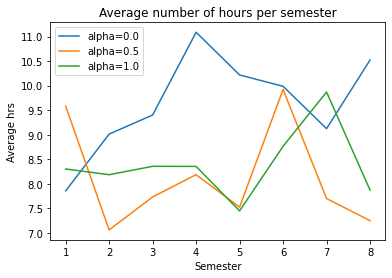

In [175]:
# Plot the values
plt.plot(results_df0['Semester'], results_df0['Hours'], label="alpha=0.0")
plt.plot(results_df5['Semester'], results_df5['Hours'], label="alpha=0.5")
plt.plot(results_df1['Semester'], results_df1['Hours'], label="alpha=1.0")

# Add labels and title
plt.xlabel('Semester')
plt.ylabel('Average hrs')
plt.title('Average number of hours per semester')
plt.legend()

# Show the plot
plt.show()

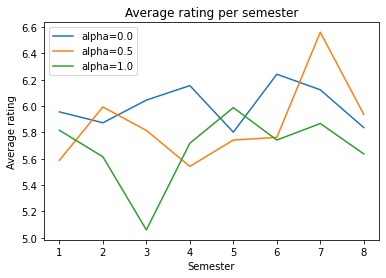

In [176]:
# Plot the values
plt.plot(results_df0['Semester'], results_df0['Ratings'], label="alpha=0.0")
plt.plot(results_df5['Semester'], results_df5['Ratings'], label="alpha=0.5")
plt.plot(results_df1['Semester'], results_df1['Ratings'], label="alpha=1.0")

# Add labels and title
plt.xlabel('Semester')
plt.ylabel('Average rating')
plt.title('Average rating per semester')
plt.legend()

# Show the plot
plt.show()

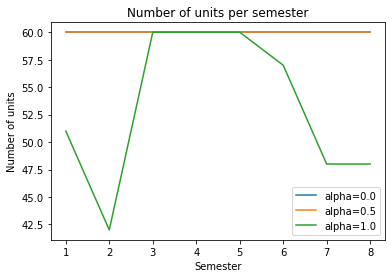

In [177]:
# Plot the values
plt.plot(results_df0['Semester'], results_df0['Units'], label="alpha=0.0")
plt.plot(results_df5['Semester'], results_df5['Units'], label="alpha=0.5")
plt.plot(results_df1['Semester'], results_df1['Units'], label="alpha=1.0")


# Add labels and title
plt.xlabel('Semester')
plt.ylabel('Number of units')
plt.title('Number of units per semester')
plt.legend()

# Show the plot
plt.show()